In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


In [ ]:
#install keras_cv
!pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 37.3 MB/s eta 0:00:00


In [ ]:
#Import libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.utils import class_weight
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow.random import gamma as tf_random_gamma
import keras_cv
from sklearn.utils import shuffle
from collections import Counter

#set random seed
seed = 42

np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
#import data from google drive
data = np.load("cleaned_data.npz")
print("Keys: ", data.keys())
X = data["X"]
Y = data["Y"]
print("Data shape: ", X.shape)
print("Label shape: ", Y.shape)

Keys:  KeysView(NpzFile 'cleaned_data.npz' with keys: X, Y)
Data shape:  (11959, 96, 96, 3)
Label shape:  (11959, 1)


In [ ]:
#split train and validation set
x_train, x_val, y_train, y_val = train_test_split(X, Y, random_state=seed, test_size=0.2, stratify=Y)


print("x_train shape: " + str(x_train.shape))
print("y_train shape: " + str(y_train.shape))
print("x_val shape: " + str(x_val.shape))
print("y_val shape: " + str(y_val.shape))

x_train shape: (9567, 96, 96, 3)
y_train shape: (9567, 1)
x_val shape: (2392, 96, 96, 3)
y_val shape: (2392, 1)


In [ ]:
#normalize data range [0,1]
x_train = (x_train/255).astype(np.float32)
x_val = (x_val/255).astype(np.float32)


#one hot encoding of Y
y_train = tfk.utils.to_categorical(y_train).astype(np.float32)
y_val = tfk.utils.to_categorical(y_val).astype(np.float32)


print("Encoded y_train shape: " + str(y_train.shape))
print("Encoded y_val shape: " + str(y_val.shape))

Encoded y_train shape: (9567, 8)
Encoded y_val shape: (2392, 8)


In [ ]:
#function that adds white noise to images
def add_white_noise(image, noise_level=0.1):
    """
    Add white noise to an image.

    Args:
        image (numpy.ndarray): Input image, normalized to [0, 1].
        noise_level (float): Standard deviation of the noise, relative to the image intensity range.

    Returns:
        numpy.ndarray: The noisy image, clipped to [0, 1].
    """
    noise = np.random.normal(loc=0.0, scale=noise_level, size=image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0.0, 1.0)


In [ ]:
#creates test set with white noise
x_test = np.copy(x_val)
for i, image in enumerate(x_test):
  x_test[i] = add_white_noise(image)

**START MIXUP**

In [ ]:
#copies x and y train
x_train_mu = np.copy(x_train)
y_train_mu = np.copy(y_train)

In [ ]:
#applies mixup to the copy of the training set
mixup = keras_cv.layers.MixUp(0.2, seed=seed)
mixed_data = mixup({'images':tf.convert_to_tensor(x_train), "labels": tf.convert_to_tensor(y_train)})
x_train_mu = mixed_data['images'].numpy()
y_train_mu = mixed_data['labels'].numpy()

In [ ]:
#concatenates the original set whit the mixed copy
x_train = np.concatenate((x_train, x_train_mu))
y_train = np.concatenate((y_train, y_train_mu))

In [ ]:
#shiffles the new set
x_train, y_train = shuffle(x_train, y_train, random_state=seed)

In [ ]:
print(y_train.shape)

(19134, 8)


In [ ]:
#creates class weights for training

weights = class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(np.argmax(y_train, axis=-1)), y=np.argmax(y_train, axis=-1).flatten())

class_weights = {}

for idx, weight in enumerate(weights):
  class_weights.update({idx:weight})

print(class_weights)

{0: 1.7586397058823529, 1: 0.6932608695652174, 2: 1.3612692088787706, 3: 0.7450934579439252, 4: 1.753482404692082, 5: 1.4827960322380658, 6: 0.6413917940466614, 7: 0.9022067144473783}


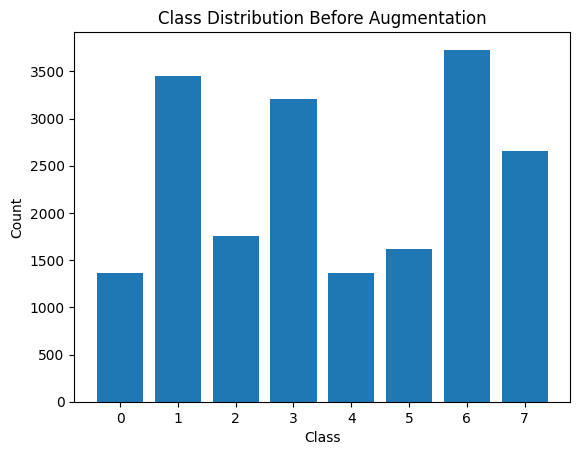

Train Class: [1360 3450 1757 3210 1364 1613 3729 2651]


In [ ]:
label, count = np.unique(np.argmax(y_train, axis=-1), return_counts=True)

# Plot the class distribution
plt.bar(range(len(label)), count)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution Before Augmentation')
plt.show()

print("Train Class:", count)

**END MIXUP**

In [ ]:
#define network parameters

input_shape = x_train.shape[1:]
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [ ]:
#define training parameters

epochs = 100
batch_size = 64
transfer_learning_lr=1e-3
fine_tuning_lr=1e-4

print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Transfer learning Rare:", transfer_learning_lr)
print("Fine tuning learning rate:", fine_tuning_lr)

Epochs: 100
Batch Size: 64
Transfer learning Rare: 0.001
Fine tuning learning rate: 0.0001


In [ ]:
# Initialise EfficientNetB2 model without pretrained weights, for custom training
net = tfk.applications.EfficientNetB2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)


# Display a summary of the model architecture
net.summary(expand_nested=True)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "efficientnetb2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 7,768,569 (29.63 MB)

 Trainable params: 7,700,994 (29.38 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [ ]:
#create augmentations layer
augmentation = tf.keras.Sequential([
    tfkl.RandomRotation(0.2, seed=seed),  # Random rotation in the range of -10 to +10 degrees (0.1 radians)
    tfkl.RandomBrightness(factor=(-0.2, 0.1), seed=seed),  # Random brightness adjustment between 0.8 and 1.2
    tfkl.RandomFlip("horizontal_and_vertical", seed=seed),
    tfkl.RandomTranslation(height_factor=0.1, width_factor=0.1, seed=seed),
], name='preprocessing')

In [ ]:

# Freeze all layers in EfficientNetB2 to use it solely as a feature extractor
net.trainable = False

# Define input layer with shape matching the input images
inputs = tfkl.Input(shape=input_shape, name='input_layer')

#apply augmentations to input
x = augmentation(inputs)

#resize input to match the size expected by efficient net
x = tfkl.Resizing(224, 224)(x)

# Pass augmented inputs through the MobileNetV3Small feature extractor
x = net(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, seed=seed, name='dropout')(x)

x = tfkl.Dense(256, activation="relu", kernel_initializer=tfk.initializers.HeUniform(seed), name="dense2")(x)

x = tfkl.Dropout(0.3, seed=seed, name='dropout2')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(output_shape, activation='softmax', kernel_initializer=tfk.initializers.HeUniform(seed), name='output')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(transfer_learning_lr), metrics=['accuracy'])

# Display a summary of the model architecture
tl_model.summary(expand_nested=True)


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_1               │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_brightness_1             │ (None, 96, 96, 3)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_1 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_1            │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb2 (Functional)          │ (None, 1408)                │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ normalization (Normalization)   │ (None, 224, 224, 3)         │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv_pad (ZeroPadding2D)   │ (None, 225, 225, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_dwconv                  │ (None, 112, 112, 32)        │             288 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_bn (BatchNormalization) │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_activation (Activation) │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,131,329 (31.02 MB)

 Trainable params: 362,760 (1.38 MB)

 Non-trainable params: 7,768,569 (29.63 MB)

In [ ]:
#creates early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)

In [ ]:
# Train the model
history = tl_model.fit(
    x=x_train*255,
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val*255, y_val),
    callbacks=[early_stopping],
    class_weight=class_weights,
    shuffle=True
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'TL_model.keras'
tl_model.save(model_filename)

# Free memory by deleting the model instance
del tl_model

Epoch 1/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 85s 235ms/step - accuracy: 0.6215 - loss: 1.1558 - val_accuracy: 0.8474 - val_loss: 0.4616
Epoch 2/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 65s 218ms/step - accuracy: 0.7896 - loss: 0.7170 - val_accuracy: 0.8880 - val_loss: 0.3598
Epoch 3/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - accuracy: 0.8107 - loss: 0.6570 - val_accuracy: 0.8863 - val_loss: 0.3528
Epoch 4/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - accuracy: 0.8252 - loss: 0.6246 - val_accuracy: 0.8984 - val_loss: 0.3102
Epoch 5/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - accuracy: 0.8271 - loss: 0.6164 - val_accuracy: 0.8926 - val_loss: 0.3235
Epoch 6/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - accuracy: 0.8327 - loss: 0.5953 - val_accuracy: 0.8959 - val_loss: 0.3126
Epoch 7/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 65s 217ms/step - accuracy: 0.8330 - loss: 0.5907 - val_accuracy: 0.9089 - val_loss: 0.2665
Epoch 8/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 65s 216ms/step - accuracy: 0.8409 -

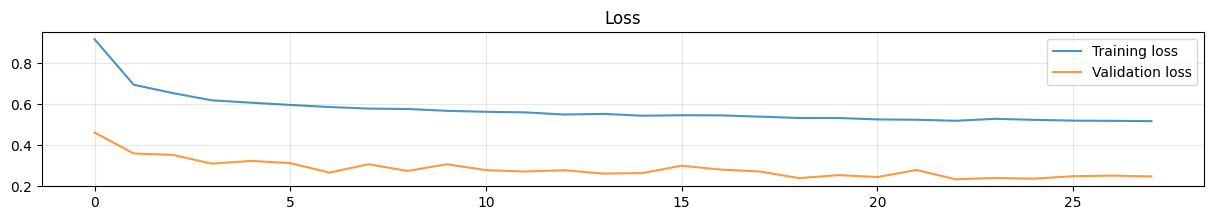

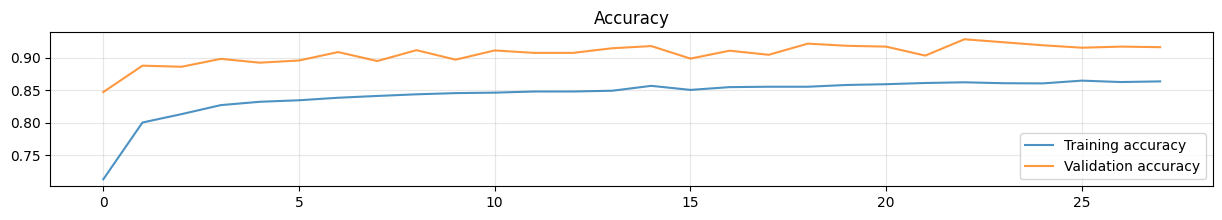

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
#loads the tl model
ft_model = tfk.models.load_model('TL_model.keras')

In [ ]:
# Set the EfficientNetB2 model layers as trainable
ft_model.get_layer('efficientnetb2').trainable = True

# Set all EfficientNetB2 layers as non-trainable
for layer in ft_model.get_layer('efficientnetb2').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('efficientnetb2').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.SeparableConv2D) or isinstance(layer, tf.keras.layers.BatchNormalization):
        print(i, layer.name, type(layer).__name__, layer.trainable)

5 stem_conv Conv2D False
6 stem_bn BatchNormalization False
9 block1a_bn BatchNormalization False
13 block1a_se_reduce Conv2D False
14 block1a_se_expand Conv2D False
16 block1a_project_conv Conv2D False
17 block1a_project_bn BatchNormalization False
19 block1b_bn BatchNormalization False
23 block1b_se_reduce Conv2D False
24 block1b_se_expand Conv2D False
26 block1b_project_conv Conv2D False
27 block1b_project_bn BatchNormalization False
30 block2a_expand_conv Conv2D False
31 block2a_expand_bn BatchNormalization False
35 block2a_bn BatchNormalization False
39 block2a_se_reduce Conv2D False
40 block2a_se_expand Conv2D False
42 block2a_project_conv Conv2D False
43 block2a_project_bn BatchNormalization False
44 block2b_expand_conv Conv2D False
45 block2b_expand_bn BatchNormalization False
48 block2b_bn BatchNormalization False
52 block2b_se_reduce Conv2D False
53 block2b_se_expand Conv2D False
55 block2b_project_conv Conv2D False
56 block2b_project_bn BatchNormalization False
59 block2c_ex

In [ ]:
# Set the number of layers to freeze
N = 0

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('efficientnetb2').layers[-N:]):
  layer.trainable = True

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('efficientnetb2').layers):
    print(i, layer.name, layer.trainable)


# Display a summary of the model architecture
ft_model.summary(expand_nested=True)


0 input_layer True
1 rescaling True
2 normalization True
3 rescaling_1 True
4 stem_conv_pad True
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block1b_dwconv True
19 block1b_bn True
20 block1b_activation True
21 block1b_se_squeeze True
22 block1b_se_reshape True
23 block1b_se_reduce True
24 block1b_se_expand True
25 block1b_se_excite True
26 block1b_project_conv True
27 block1b_project_bn True
28 block1b_drop True
29 block1b_add True
30 block2a_expand_conv True
31 block2a_expand_bn True
32 block2a_expand_activation True
33 block2a_dwconv_pad True
34 block2a_dwconv True
35 block2a_bn True
36 block2a_activation True
37 block2a_se_squeeze True
38 block2a_se_reshape True
39 block2a_se_reduce True
40 block2a_se_expand True
41 bl

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_1               │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_brightness_1             │ (None, 96, 96, 3)           │               0 │
│ (RandomBrightness)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_1 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_1            │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb2 (Functional)          │ (None, 1408)                │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ normalization (Normalization)   │ (None, 224, 224, 3)         │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv_pad (ZeroPadding2D)   │ (None, 225, 225, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_dwconv                  │ (None, 112, 112, 32)        │             288 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_bn (BatchNormalization) │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_activation (Activation) │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,856,851 (33.79 MB)

 Trainable params: 8,063,754 (30.76 MB)

 Non-trainable params: 67,575 (263.97 KB)

 Optimizer params: 725,522 (2.77 MB)

In [ ]:
#compiles the new model for FT
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(fine_tuning_lr), metrics=['accuracy'])


In [ ]:
#creates callbacks for training
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
reduce_lr = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

In [ ]:
# Train the model
history = ft_model.fit(
    x=x_train*255,
    y=y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val*255, y_val),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights,
    shuffle=True
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'SubmissionModel.keras'
ft_model.save(model_filename)

# Free memory by deleting the model instance
del ft_model


Epoch 1/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 335s 944ms/step - accuracy: 0.7268 - loss: 1.1554 - val_accuracy: 0.9590 - val_loss: 0.1191 - learning_rate: 1.0000e-04
Epoch 2/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 278s 929ms/step - accuracy: 0.9346 - loss: 0.3568 - val_accuracy: 0.9774 - val_loss: 0.0642 - learning_rate: 1.0000e-04
Epoch 3/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 278s 929ms/step - accuracy: 0.9517 - loss: 0.3073 - val_accuracy: 0.9829 - val_loss: 0.0559 - learning_rate: 1.0000e-04
Epoch 4/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 278s 928ms/step - accuracy: 0.9622 - loss: 0.2696 - val_accuracy: 0.9833 - val_loss: 0.0462 - learning_rate: 1.0000e-04
Epoch 5/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 277s 928ms/step - accuracy: 0.9640 - loss: 0.2540 - val_accuracy: 0.9858 - val_loss: 0.0410 - learning_rate: 1.0000e-04
Epoch 6/100
299/299 ━━━━━━━━━━━━━━━━━━━━ 277s 928ms/step - accuracy: 0.9695 - loss: 0.2371 - val_accuracy: 0.9841 - val_loss: 0.0459 - learning_rate: 1.0000e-04
Epoch 7/100
299/299 ━━━━━━━━━━━━━━

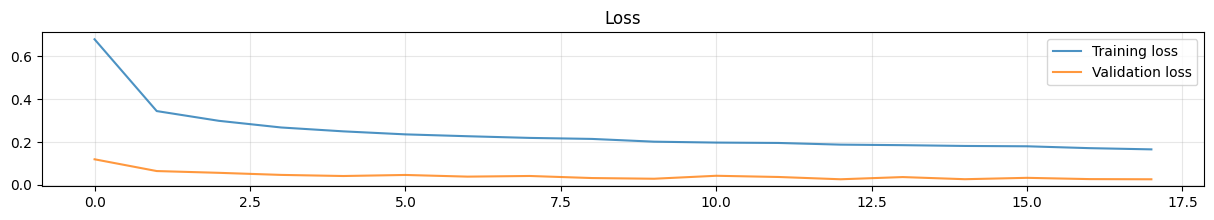

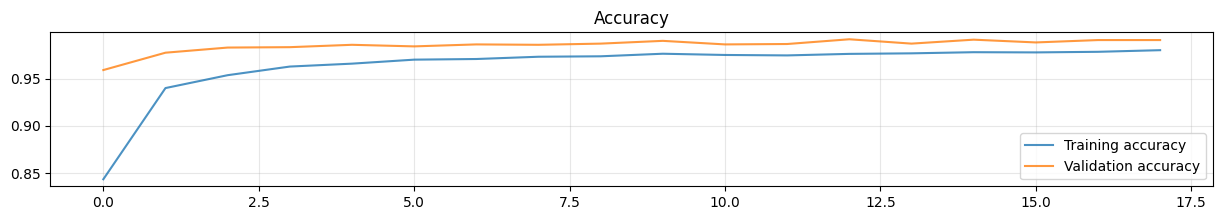

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Predictions Shape: (2392,)
Accuracy: 0.9231
Precision: 0.9273
Recall: 0.9231
F1: 0.9219


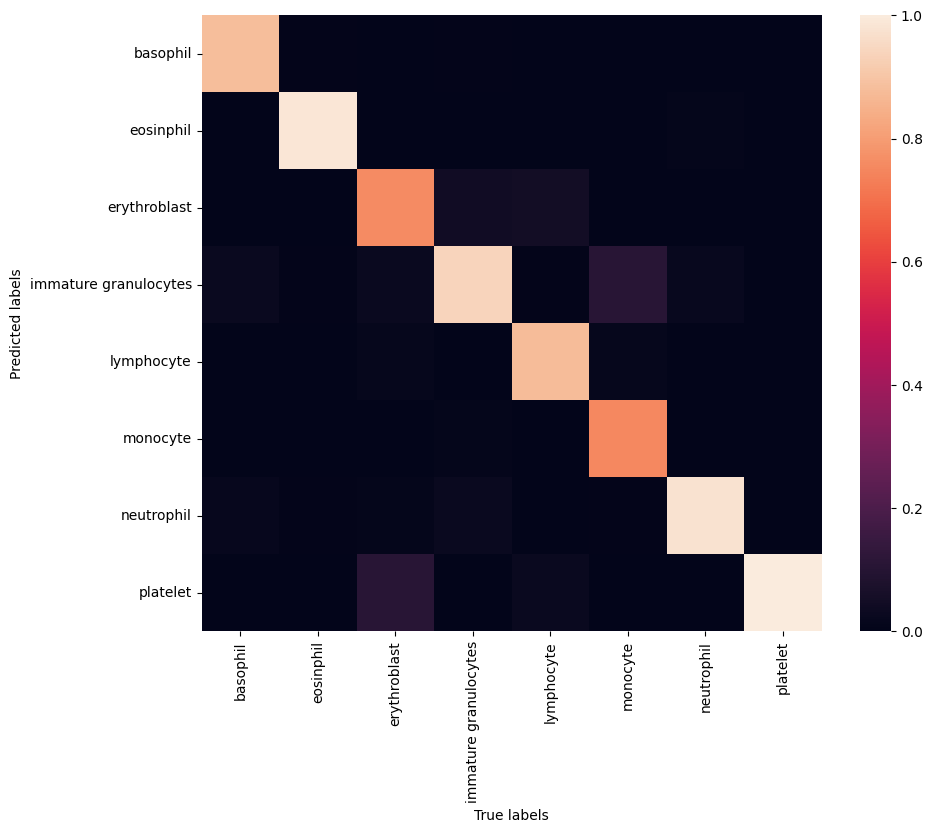

In [ ]:
# Plot confusion matrix


# Load the saved model
model = tfk.models.load_model('SubmissionModel.keras')

# Predict labels for the entire test set
predictions = model.predict((x_test*255), verbose=0) #x_test is different from x_val used during training
predictions = np.argmax(predictions, axis=-1)
true_y = np.argmax(y_val, axis=-1)

del model

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

labels = {0:"basophil",
           1:"eosinphil",
           2:"erythroblast",
           3:"immature granulocytes",
           4:"lymphocyte",
           5:"monocyte",
           6:"neutrophil",
           7:"platelet"
           }



# Compute the confusion matrix
cm = confusion_matrix(true_y, predictions)

# Compute the classification metrics
accuracy = accuracy_score(true_y, predictions)
precision = precision_score(true_y, predictions, average='weighted')
recall = recall_score(true_y, predictions, average='weighted')
f1 = f1_score(true_y, predictions, average='weighted')
print('Accuracy:',round(accuracy, 4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

cm = cm /cm.astype(float).sum(axis=1);

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
#prints all the parameters of the predictions
print( classification_report(true_y, predictions))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       170
           1       0.99      0.99      0.99       436
           2       0.89      0.76      0.82       217
           3       0.83      0.94      0.88       405
           4       0.97      0.88      0.92       170
           5       0.99      0.75      0.85       199
           6       0.94      0.97      0.95       466
           7       0.88      1.00      0.94       329

    accuracy                           0.92      2392
   macro avg       0.93      0.90      0.91      2392
weighted avg       0.93      0.92      0.92      2392

